In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from code.company_data_pipeline import *
from code.ticker_data_pipeline import *
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

In [106]:
s = get_series_list_from_files(limit=5000, min_mean_price_dollars=25)

In [107]:
len(s)

841

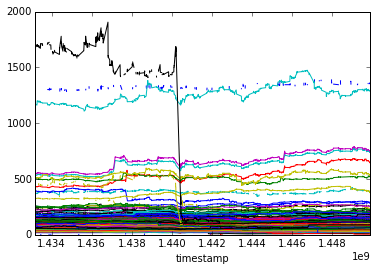

In [108]:
# Data! Horray!
df = pd.DataFrame(data=s).T
df.plot(legend=False)

In [109]:
# Deal with missing values
df = df.interpolate().fillna(method='bfill')

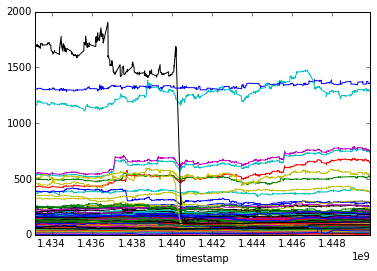

In [110]:
df.plot(legend=False)

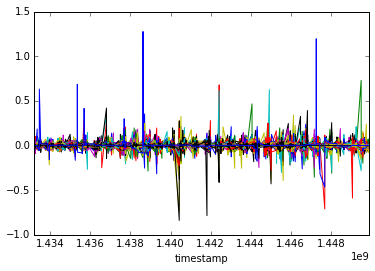

In [111]:
dif_df = df.pct_change().clip(-2, 2).fillna(0.)
dif_df.plot(legend=False)

In [112]:
# X[0] is now NAs because we diffed
X = dif_df.values[1:]
X

array([[ 0.        , -0.00377181, -0.00369089, ..., -0.00989739,
        -0.00327022,  0.        ],
       [ 0.        , -0.00118315, -0.00138921, ...,  0.01396545,
         0.00155414,  0.        ],
       [ 0.        , -0.00047382, -0.00123657, ...,  0.01739761,
        -0.00224138,  0.        ],
       ..., 
       [ 0.0064538 , -0.00652681,  0.00155578, ..., -0.00225577,
         0.        ,  0.        ],
       [ 0.00371245,  0.00164242,  0.00127053, ...,  0.00626087,
         0.00044553,  0.        ],
       [ 0.00302623, -0.00562193, -0.00228793, ...,  0.00241963,
         0.00044534,  0.        ]])

In [113]:
dif_df.columns

Index([u'aaap', u'aal', u'aapl', u'aaww', u'abax', u'abcb', u'abco', u'abcw',
       u'abmd', u'acad',
       ...
       u'yhoo', u'yy', u'z', u'zbra', u'zfgn', u'zg', u'zion', u'zltq',
       u'zsph', u'zvv'],
      dtype='object', length=841)

In [114]:
# Load data about the companies
with open(PROJECT_HOME + 'data/company/nasdaq_descriptions.tsv') as f:
    company_df = pd.read_csv(f, 
                         sep='\t', 
                         header=None)
company_df.columns = ['ticker', 'description']
company_df = company_df.dropna().set_index('ticker')

tv = TfidfVectorizer(stop_words='english')
tfidf = tv.fit_transform(company_df.description)
features = np.array(tv.get_feature_names())
# Change the 2d array to a list of 1d arrays
tfidf = map(lambda x: x.flatten(), np.vsplit(tfidf.toarray(), tfidf.shape[0]))
company_df['tfidf'] = tfidf
company_df.head()

,description,tfidf
ticker,,
aaap,We are an innovative radiopharmaceutical compa...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aal,"American Airlines Group Inc. (AAG), a Delaware...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aame,"Atlantic American Corporation, a Georgia corpo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aaoi,This report contains forward-looking statement...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aaon,"AAON, Inc., a Nevada corporation, (""AAON Nevad...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [115]:
# Throw out comapanies where we don't have a good description
company_df = company_df[company_df.description.apply(lambda x: len(x) > 100)]

In [125]:
n_components=25
factorization = PCA(n_components=n_components, whiten=True)
factorization.fit(X)

PCA(copy=True, n_components=25, whiten=True)

In [212]:
comp_companies_pro = {}
comp_companies_con = {}
companies_pro_index = []
companies_con_index = []

for component in range(n_components):
    idx = np.argsort(factorization.components_[component])[:15]
    companies_pro_index.append(idx)
    comp_companies_pro[component] = df.columns[idx]
    # print comp_companies[component]
    # print np.sort(pca.components_[component])[:20]
    idx = np.argsort(factorization.components_[component])[::-1][:15]
    companies_con_index.append(idx)
    comp_companies_con[component] = df.columns[idx]

In [214]:
factorization.components_[2][companies_con_index[2]]

array([ 0.1692752 ,  0.1460551 ,  0.14020594,  0.11252633,  0.1081229 ,
        0.10641018,  0.10542468,  0.10187113,  0.10183259,  0.10066403,
        0.09988458,  0.09986871,  0.09970311,  0.09523539,  0.09502744])

In [175]:
i = 1

importances_pro = company_df.ix[comp_companies_pro[i], :]['tfidf'].mean()
word_indicies_pro = importances_pro.argsort()[::-1][:20]
print "pro:"
print "companies: ", comp_companies_pro[i]
print "words: ", features[word_indicies_pro]
print "word importances", importances_pro[word_indicies_pro]
print ""

word_indicies_con = company_df.ix[comp_companies_con[i], :]['tfidf'].mean().argsort()[::-1][:25]
print features[word_indicies_con]

pro:
companies:  Index([u'zvv', u'clvs', u'vxdn', u'aaap', u'zfgn', u'jd', u'powi', u'crus',
       u'vrts', u'vxup', u'strt', u'aal', u'nflx', u'bsft', u'arii'],
      dtype='object')
words:  [u'railcar' u'obesity' u'voltage' u'pnx' u'uc' u'company' u'cirrus'
 u'airways' u'amr' u'aag' u'mnm' u'lutathera' u'cancer' u'internet'
 u'logic' u'360buy' u'jingdong' u'american' u'shows' u'hosted']
word importances [ 0.07000295  0.05690442  0.04811012  0.04465953  0.03873087  0.03772792
  0.03743273  0.03740091  0.03504878  0.03504878  0.0308285   0.0308285
  0.03040263  0.03022821  0.03015152  0.02931075  0.02931075  0.02914244
  0.02778747  0.02690387]

[u'drug' u'diseases' u'martin' u'injectable' u'dispatch' u'generic'
 u'auxilium' u'nda' u'treatment' u'fda' u'biomedicine' u'credit' u'areas'
 u'pharmaceuticals' u'ventricular' u'genomically' u'company' u'patiromer'
 u'statements' u'inhibitor' u'pharmaceutical' u'annual' u'development'
 u'branded' u'ljpc']


In [237]:
def draw_importances_graph(names, importances, title, ax):
    n = len(names)
    #ax.figure()
    ax.set_title(title, fontdict={'fontsize': 30})
    ax.bar(range(n), importances,
           color="r", align="center")
    ax.set_xticks(range(n))
    ax.set_xticklabels(names, rotation='vertical')
    ax.set_xlim([-1, n])
    labels = ax.get_xticks()
    ax.tick_params(labelsize=20)

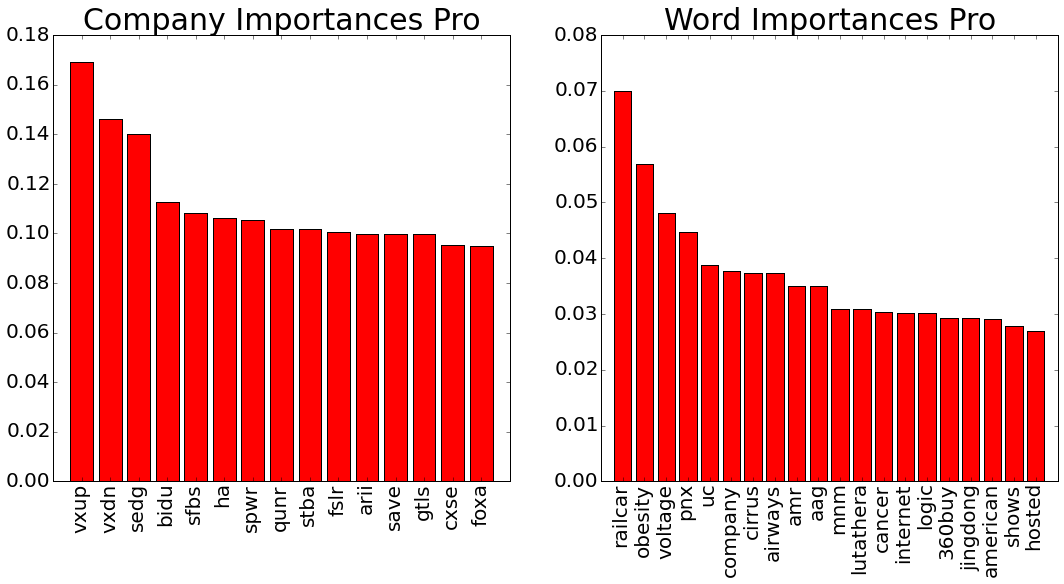

In [240]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
draw_importances_graph(features[word_indicies_pro],
                       importances_pro[word_indicies_pro], 
                       "Word Importances Pro",
                       ax2)

draw_importances_graph(comp_companies_pro[2],
                       factorization.components_[2][companies_con_index[2]], 
                       "Company Importances Pro",
                       ax1)


In [62]:
# We can clean up the data and get better results by finding a way to dedupe the list of
# companies.  Some are subsidiaries of the others and track very closely.  These are then 
# overrepresented in the data.

array([    0, 11388, 11389, ..., 11487, 13147, 15032])

In [143]:
# Biotech and pharma seems to be overrepresented in the data.  What is going on with 
# that.  

In [144]:
# We could try daily instead of hourly.  